# Mean-Field Optimal Execution - FBSDE method report

> Tip: The notebook assumes `mf_optimal_execution` package is installed (editable mode is fine):  
> `pip install -e ..` and restart the kernel.

In [1]:
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from mf_optimal_execution.models import PriceImpactModel
from mf_optimal_execution.solutions import OptimalExecutionSolutionPDE_MFG
from mf_optimal_execution.networks import FBSDEModel_MFG
from mf_optimal_execution.utils import setup_plt
from mf_optimal_execution.config import Config

In [2]:
CHECKPOINTS_PATH = Path("../checkpoints")

checkpoint_path = None
if checkpoint_path is None:
    candidates = sorted((p for p in CHECKPOINTS_PATH.glob("fbsde_mfg_*.pt")), key=lambda p: p.stat().st_mtime, reverse=True)
    checkpoint_path = candidates[0]

print(f"Will load: '{checkpoint_path.name}'")

Will load: 'fbsde_mfg_1760035281.pt'


## Load checkpoint

In [3]:
setup_plt()

ckpt = torch.load(checkpoint_path)

cfg = Config(**ckpt["config"])


dyn = PriceImpactModel(cfg.sigma, cfg.gamma, cfg.ca, cfg.cx, cfg.cg)
sol = OptimalExecutionSolutionPDE_MFG(dyn, cfg)

# Recreate and load model
model = FBSDEModel_MFG(dyn, cfg.maturity)
model.load_state_dict(ckpt["model"], strict=True)
model.eval()

# Training curves
losses = ckpt.get("losses", None)
mean_errors = ckpt.get("mean_errors", None)
std_errors = ckpt.get("std_errors", None)

## Plot results

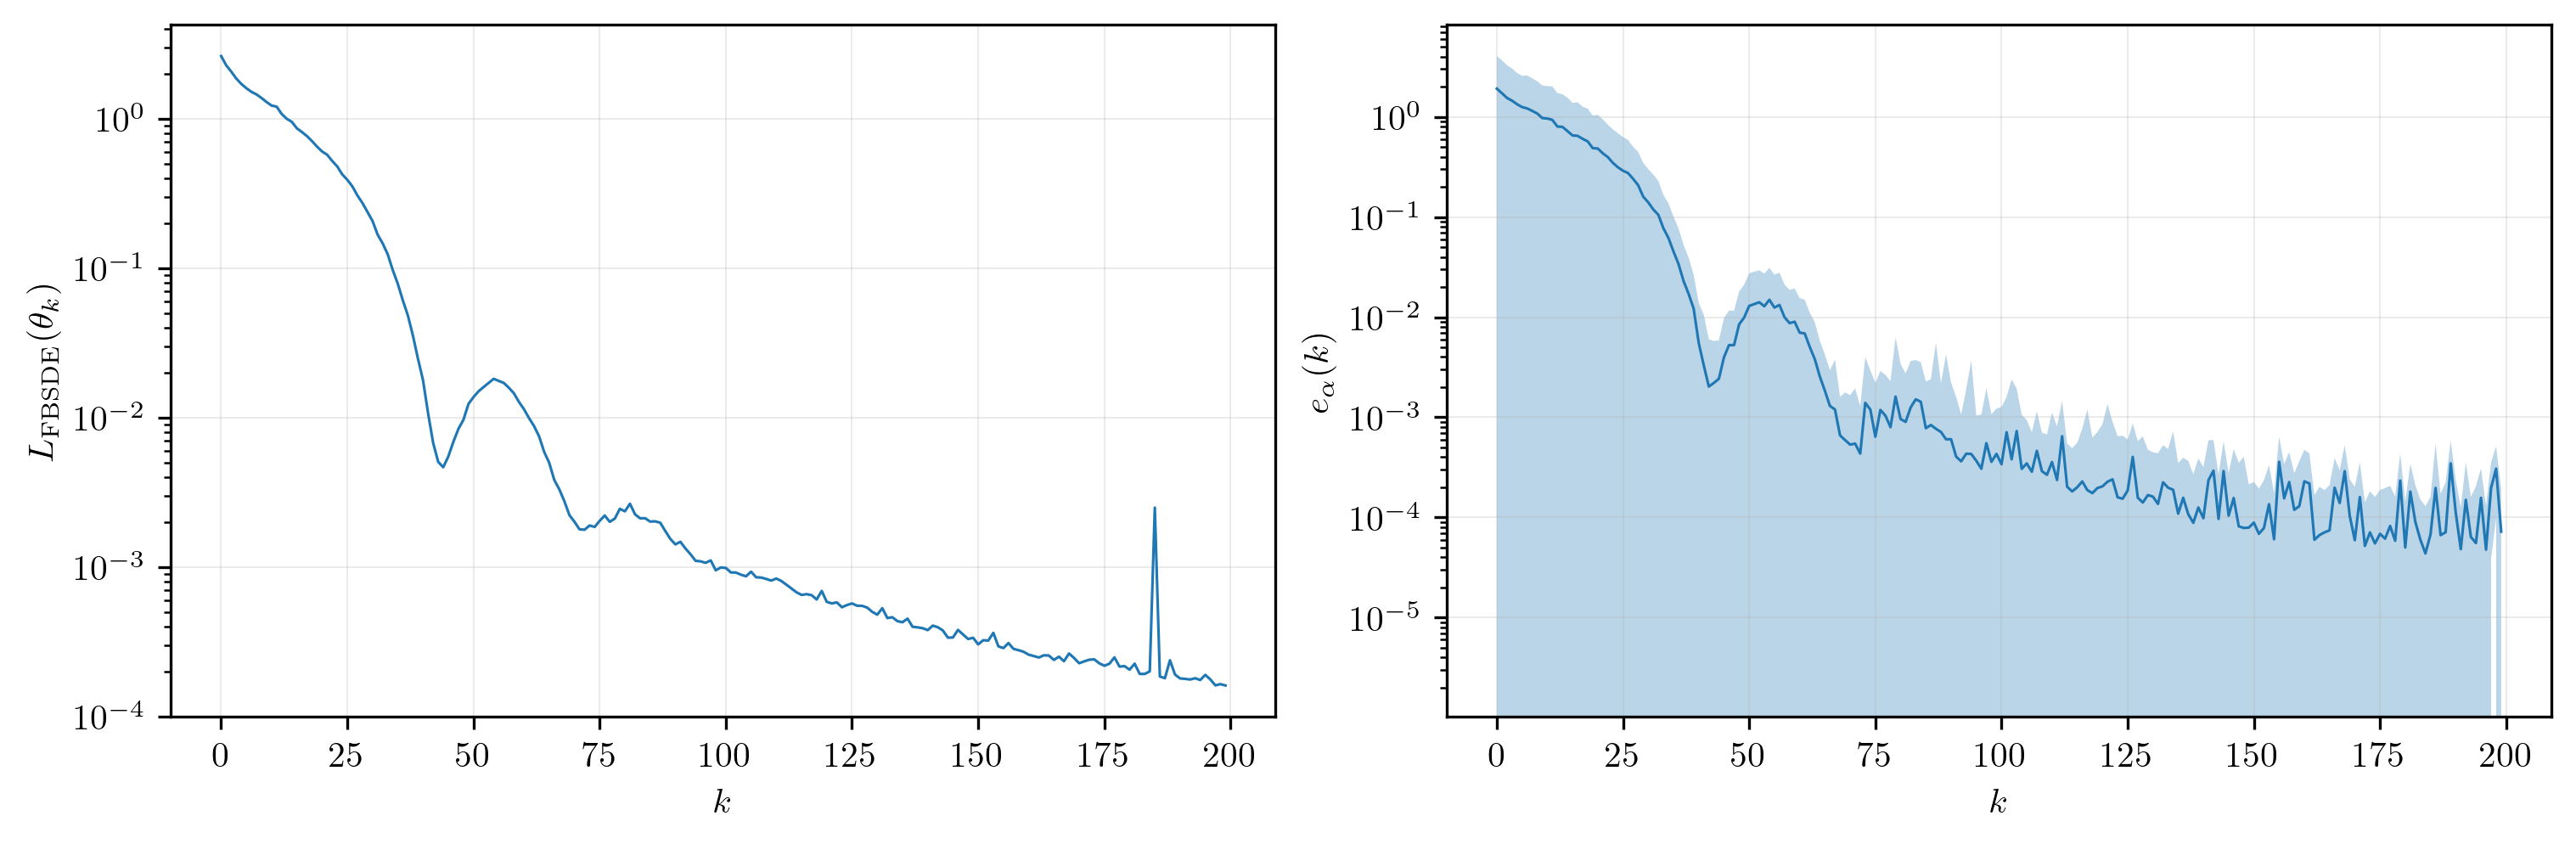

In [4]:
x_epoch = torch.arange(len(losses))

fig, axs = plt.subplots(1, 2, figsize=(10, 3.2), dpi=300, constrained_layout=True)

axs[0].plot(x_epoch, losses, lw=0.75)
axs[0].set_xlabel("$k$")
axs[0].set_ylabel(r"$L_{\mathrm{FBSDE}}(\theta_k)$")
axs[0].set_yscale("log")
axs[0].grid(lw=0.5, alpha=0.25)

axs[1].plot(x_epoch, mean_errors, lw=0.75)
axs[1].fill_between(x_epoch, mean_errors - std_errors, mean_errors + std_errors, alpha=0.3)
axs[1].set_xlabel("$k$")
axs[1].set_ylabel(r"$e_\alpha(k)$")
axs[1].set_yscale("log")
axs[1].grid(lw=0.5, alpha=0.25)

plt.show()

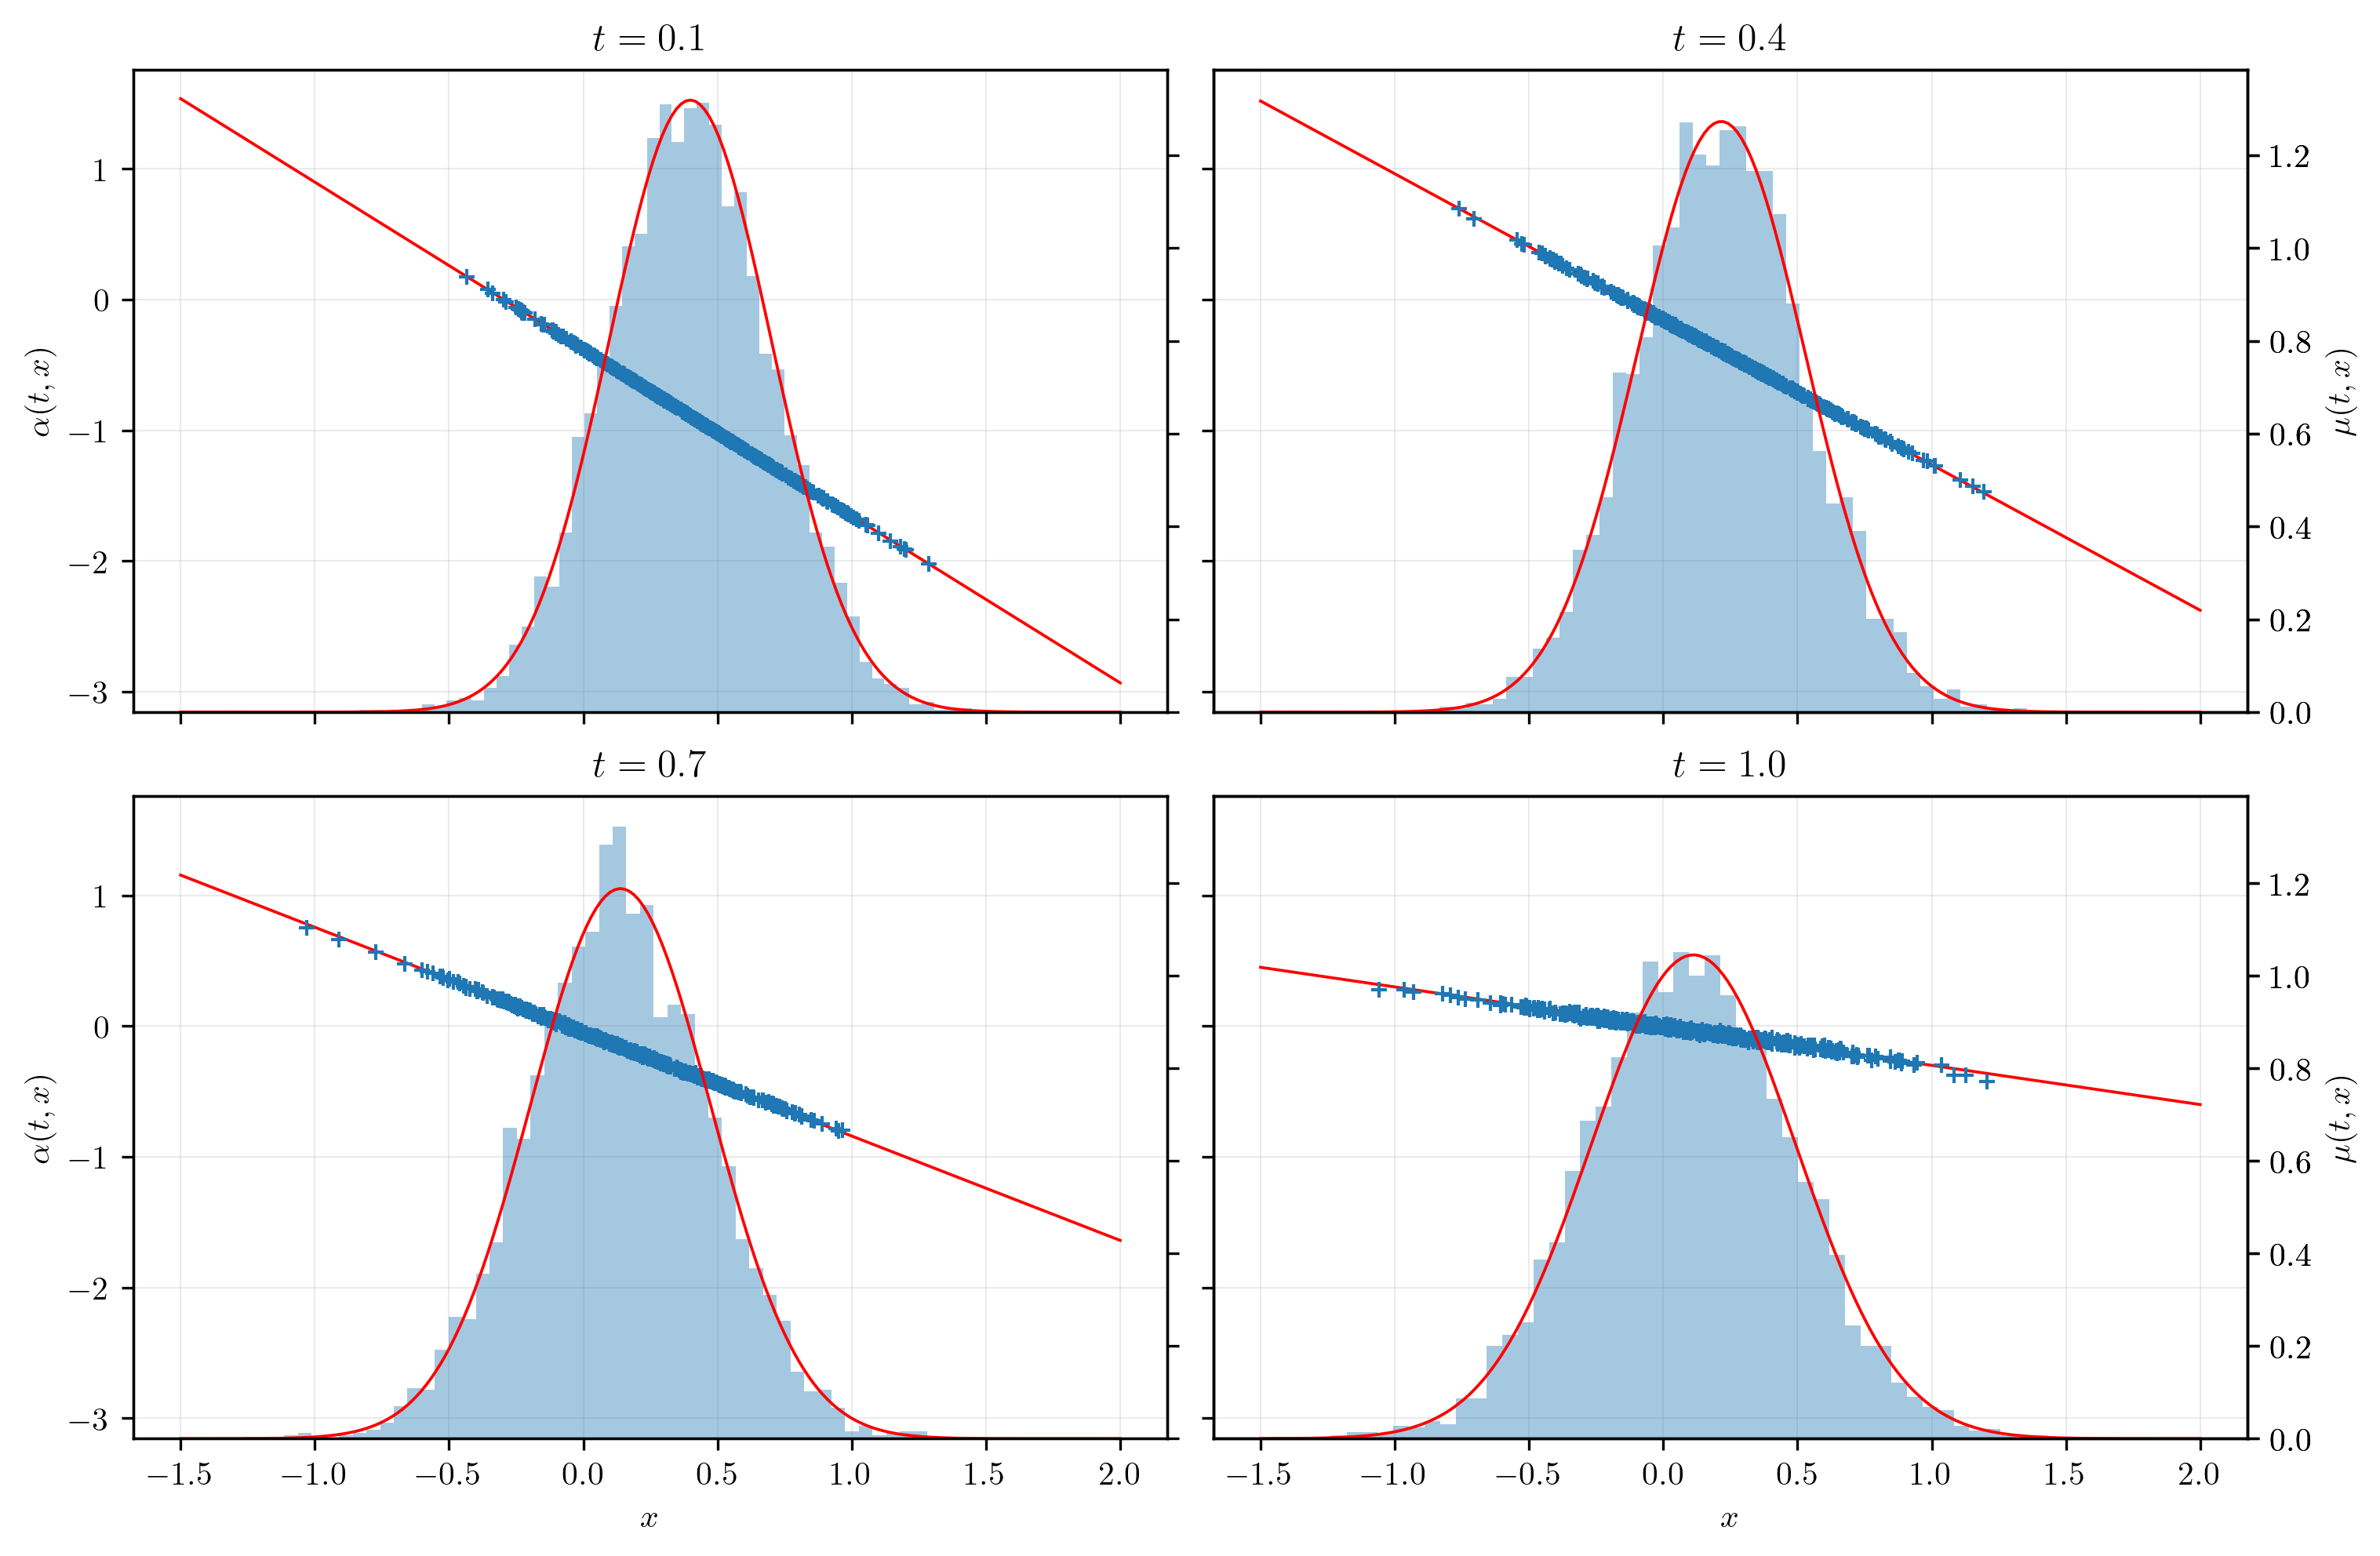

In [5]:
n_sample = 5_000
time_step = 200
dt = cfg.maturity / time_step

t = torch.linspace(0, cfg.maturity, time_step + 1)
x = cfg.x0_std * torch.randn((n_sample, 1)) + cfg.x0_mean
dw = dt**0.5 * torch.randn((n_sample, time_step, 1))

xs, ys = model.build_trajectories(x, dw)

xx = torch.linspace(-1.5, 2.0, 200)
i_values = np.linspace(0.1, 1, 4)

fig, axs = plt.subplots(2, 2, figsize=(10, 6.5), dpi=300, sharex=True, sharey=True, constrained_layout=True)

for row in range(2):
    ax = axs[row]
    rax0 = ax[0].twinx()
    rax1 = ax[1].twinx()

    rax1.sharey(rax0)

    i = int(i_values[2 * row] * time_step)
    ax[0].plot(xx, sol.alpha(i * dt, xx), c="red", lw=0.9)
    ax[0].plot(xs[:500, i], -ys[:500, i] / cfg.ca, "+", ms=5, c="tab:blue")
    ax[0].set_ylabel(r"$\alpha(t,x)$")
    if row == 1:
        ax[0].set_xlabel(f"$x$")
    ax[0].set_title(f"$t={i*dt:.1f}$")
    ax[0].grid(lw=0.5, alpha=0.25)

    rax0.plot(xx, sol.x_pdf(i * dt, xx), c="red", lw=0.9)
    rax0.hist(xs[:, i], density=True, bins=50, alpha=0.4, color="tab:blue")
    rax0.set_xlabel(r"$x$")

    i = int(i_values[2 * row + 1] * time_step)
    ax[1].plot(xx, sol.alpha(i * dt, xx), c="red", lw=0.9)
    ax[1].plot(xs[:500, i], -ys[:500, i] / cfg.ca, "+", ms=5)
    if row == 1:
        ax[1].set_xlabel(f"$x$")
    ax[1].set_title(f"$t={i*dt:.1f}$")
    ax[1].grid(lw=0.5, alpha=0.25)

    rax1 = ax[1].twinx()
    rax1.plot(xx, sol.x_pdf(i * dt, xx), c="red", lw=0.9)
    rax1.hist(xs[:, i], density=True, bins=50, alpha=0.4, color="tab:blue")
    rax1.set_ylabel(r"$\mu(t,x)$")

    for ax in (rax0, rax1):
        ax.relim()
        ax.autoscale_view()
    ymin = min(rax0.get_ylim()[0], rax1.get_ylim()[0])
    ymax = max(rax0.get_ylim()[1], rax1.get_ylim()[1])
    rax1.set_ylim(ymin, ymax)
    rax0.tick_params(axis="y", which="both", labelright=False)

plt.show()